In [9]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [64]:
import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import polars as pl
import os
import torch.nn.functional as F

class PronunciationDataset(Dataset):
    def __init__(self, data: pl.DataFrame, base_dir, sample_rate=22050, n_mels=128):
        self.data = data
        self.base_dir = base_dir
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.mel_spectrogram = T.MelSpectrogram(
            sample_rate=sample_rate,
            n_mels=n_mels,
            n_fft=1024,
            hop_length=512,
        )
        self.amplitude_to_db = T.AmplitudeToDB()

    def __len__(self):
        return self.data.height

    def __getitem__(self, idx):
        row = self.data.row(idx)
        rec_path = row[3]
        label = row[1]
        full_path = os.path.normpath(os.path.join(self.base_dir, rec_path))
        waveform, sr = torchaudio.load(full_path)

        if not os.path.exists(full_path):
            raise FileNotFoundError(f"Audio file not found: {full_path}")
        
        # 🔧 Convert to mono if needed
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # 🔄 Resample
        if sr != self.sample_rate:
            waveform = T.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

        # ✂️ Voice Activity Detection
        trimmed_waveform = torchaudio.functional.vad(waveform, sample_rate=self.sample_rate)
        if trimmed_waveform.numel() == 0:
            trimmed_waveform = waveform  # fallback to original

        # 🎛️ Log-Mel features
        mel_spec = self.mel_spectrogram(trimmed_waveform)
        log_mel_spec = self.amplitude_to_db(mel_spec)
        log_mel_spec = (log_mel_spec - log_mel_spec.mean()) / (log_mel_spec.std() + 1e-6)

        return log_mel_spec, torch.tensor(label, dtype=torch.float32)




In [40]:
def collate_fn(batch):
    specs, labels = zip(*batch)
    # Pad/truncate time dimension to max_len (e.g., 128 frames)
    max_len = 128
    padded_specs = []
    for spec in specs:
        # spec shape: [1, n_mels, time]
        if spec.shape[2] < max_len:
            pad_amount = max_len - spec.shape[2]
            spec = F.pad(spec, (0, pad_amount))
        else:
            spec = spec[:, :, :max_len]
        padded_specs.append(spec)
    specs_tensor = torch.stack(padded_specs)
    labels_tensor = torch.tensor(labels)
    return specs_tensor, labels_tensor

In [ ]:
from data.source.pg_experiment import get_pg_experiment_dataset, AUDIO_PATH
import polars as pl

df_pron, _ = get_pg_experiment_dataset(".wav")
df_stageI_polish = df_pron.filter(pl.col("word_id").str.starts_with("a") & pl.col("mother")
    .str.strip_chars()
    .str.to_lowercase()
    .is_in(["polish", "polski"]))


In [92]:
df_other_lang = df_pron.filter(
    pl.col("word_id").str.starts_with("a") &
    (~pl.col("mother")
       .str.strip_chars()
       .str.to_lowercase()
       .is_in(["polish", "polski"]))
)


In [ ]:

dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

epochs = 10
for epoch in range(epochs):
    loss = train(model, dataloader, optimizer, criterion, device)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

Epoch 1, Loss: 0.6681
Epoch 2, Loss: 0.6379
Epoch 3, Loss: 0.6176
Epoch 4, Loss: 0.6021
Epoch 5, Loss: 0.5846
Epoch 6, Loss: 0.5572
Epoch 7, Loss: 0.5329
Epoch 8, Loss: 0.5086
Epoch 9, Loss: 0.4753
Epoch 10, Loss: 0.4344


In [93]:
count_missing = 0
rec_paths = df_other_lang.select("rec_path").to_series()

for path in rec_paths:
    full_path = os.path.normpath(os.path.join(AUDIO_PATH, path))
    if not os.path.exists(full_path):
        count_missing += 1

print(f"Missing files: {count_missing}")

Missing files: 2


In [96]:
dataset = PronunciationDataset(df_stageI_polish, base_dir=AUDIO_PATH)
dataset_other = PronunciationDataset(df_other_lang ,base_dir=AUDIO_PATH)

In [43]:
print(len(dataset))  # total number of samples


6018


In [49]:
spec, label = dataset[5]
print("Spec shape:", spec.shape)  # Should be [1, n_mels, time_frames]
print("Label:", label)


Spec shape: torch.Size([1, 128, 38])
Label: tensor(0.)


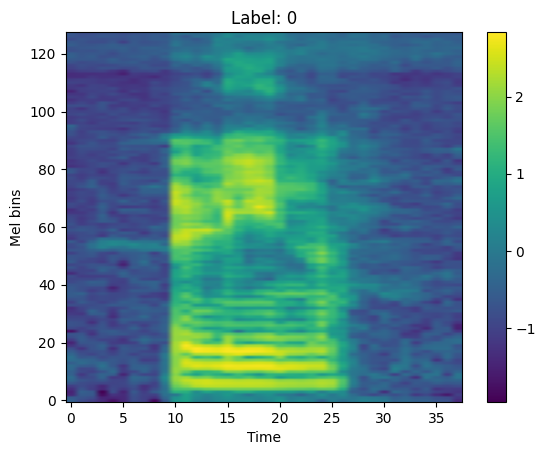

In [52]:
import matplotlib.pyplot as plt

spec_np = spec.squeeze(0).numpy()  # [n_mels, time]
plt.imshow(spec_np, origin="lower", aspect="auto")
plt.title(f"Label: {int(label.item())}")
plt.xlabel("Time")
plt.ylabel("Mel bins")
plt.colorbar()
plt.show()


In [44]:
for i in range(5):
    spec, label = dataset[i]
    print(f"Sample {i}: shape={spec.shape}, label={label.item()}")


Sample 0: shape=torch.Size([1, 128, 57]), label=0.0
Sample 1: shape=torch.Size([1, 128, 40]), label=1.0
Sample 2: shape=torch.Size([1, 128, 75]), label=0.0
Sample 3: shape=torch.Size([1, 128, 62]), label=1.0
Sample 4: shape=torch.Size([1, 128, 53]), label=0.0


In [57]:
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
batch_specs, batch_labels = next(iter(loader))
print("Batch specs:", batch_specs.shape)  # [B, 1, n_mels, time]
print("Batch labels:", batch_labels)


Batch specs: torch.Size([4, 1, 128, 128])
Batch labels: tensor([0., 1., 0., 1.])


In [62]:
import torch.nn as nn

# Simple CNN for binary classification on log-Mel inputs
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # adjust input size after pooling
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B,16,H/2,W/2]
        x = self.pool(F.relu(self.conv2(x)))  # [B,32,H/4,W/4]
        x = self.pool(F.relu(self.conv3(x)))  # [B,64,H/8,W/8]
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return torch.sigmoid(x).squeeze(1)
    
    # Training loop
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for specs, labels in dataloader:
        specs, labels = specs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(specs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * specs.size(0)
    return total_loss / len(dataloader.dataset)

In [87]:

dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

epochs = 10
for epoch in range(epochs):
    loss = train(model, dataloader, optimizer, criterion, device)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

Epoch 1, Loss: 0.6681
Epoch 2, Loss: 0.6379
Epoch 3, Loss: 0.6176
Epoch 4, Loss: 0.6021
Epoch 5, Loss: 0.5846
Epoch 6, Loss: 0.5572
Epoch 7, Loss: 0.5329
Epoch 8, Loss: 0.5086
Epoch 9, Loss: 0.4753
Epoch 10, Loss: 0.4344


In [88]:
from path import RESULT_DIRECTORY

torch.save(model.state_dict(), os.path.join(RESULT_DIRECTORY, "initial_model.pth"))


In [89]:
model_saved = SimpleCNN()
model_saved.load_state_dict(torch.load(os.path.join(RESULT_DIRECTORY, "initial_model.pth")))
model_saved.to(device)
model_saved.eval()

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [99]:
from torch.utils.data import DataLoader

# Create DataLoader for other dataset (batch_size=1 for per-sample inference)
other_loader = DataLoader(dataset_other, batch_size=1, shuffle=False, collate_fn=collate_fn)

model.eval()
with torch.no_grad():
    for i, (spec, label) in enumerate(other_loader):
        if i == 10:
            break
        spec = spec.to(device)
        output = model_saved(spec)
        pred = (output > 0.5).float()
        print(f"Sample {i+1}: Prediction={pred.item()}, Ground Truth={label.item()}")


Sample 1: Prediction=1.0, Ground Truth=1.0
Sample 2: Prediction=0.0, Ground Truth=0.0
Sample 3: Prediction=0.0, Ground Truth=0.0
Sample 4: Prediction=1.0, Ground Truth=0.0
Sample 5: Prediction=0.0, Ground Truth=1.0
Sample 6: Prediction=1.0, Ground Truth=1.0
Sample 7: Prediction=0.0, Ground Truth=0.0
Sample 8: Prediction=0.0, Ground Truth=1.0


LibsndfileError: Error opening 'c:\\Users\\fisch\\Documents\\studiaMagisterskie\\sem1\\zespolowyProjektBadawczy\\repo\\Mandarin_Pronunciation_Recognition_Project\\data\\source\\pg_dataset\\recordings\\stageI\\757\\a0.wav': System error.